In [1]:
import tensorflow as tf

In [5]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

1


In [12]:
# List all physical devices (CPUs and GPUs)
physical_devices = tf.config.experimental.list_physical_devices()

# List only GPUs
gpus = [device for device in physical_devices if device.device_type == 'GPU']

if gpus:
    # Print GPU information
    for gpu in gpus:
        print("GPU Name:", gpu.name)
else:
    print("No GPUs found")


GPU Name: /physical_device:GPU:0


In [6]:
import src.MCTS as MCTS
from src.Environments import StatelessGym
from src.Experiment import Experiment, RandomExperiment, ParametrizedRandomExperiment
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_log_error, max_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.preprocessing import OneHotEncoder
import ast
import math
import argparse
import tensorflow as tf

def encode_maze(maze):
    num_rows = len(maze)
    num_cols = len(maze[0])

    encoded_maze = []

    for i in range(num_rows):
        for j in range(num_cols):
            if maze[i][j] == 'S':
                encoded_maze.append(0)
            elif maze[i][j] == 'F':
                encoded_maze.append(1)
            elif maze[i][j] == 'H':
                encoded_maze.append(2)
            elif maze[i][j] == 'G':
                encoded_maze.append(3)
            elif maze[i][j] == 'E':
                encoded_maze.append(4)
    return encoded_maze

def add_padding(map, target_size):
    current_size = len(map)
    diff = target_size - current_size
    if diff < 0:
        raise Exception("Current map size is greater than target size")
    elif diff == 0:
        return map
    else:
        result = []
        padding = diff // 2
        left_out = diff % 2
        for i in range(padding):
            result.append('E' * target_size)
        for row in map:
            new_row = 'E' * padding + row + 'E' * padding + 'E' * left_out
            result.append(new_row)
        for i in range(padding + left_out):
            result.append('E' * target_size)
        return result
    
def encode_map(map, categories='auto'):
    # Convert the map to a 2D array
    map_array =  []
    for row in map:
        for letter in row:
            map_array.append([letter])
    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False, categories=categories)

    # Fit and transform the map array
    encoded_map = encoder.fit_transform(map_array).astype('int64')

    # Get the categories (unique values) from the encoder
    categories = encoder.categories_[0]

    # Create a dictionary to map the encoded values to the original categories
    category_mapping = {i: category for i, category in enumerate(categories)}

    # Return the encoded map and the category mapping
    return encoded_map, encoder.categories_, category_mapping

            
def file_dir(relative_path):
    absolute_path = os.path.dirname(__file__)
    return os.path.join(absolute_path, relative_path)

In [13]:
directory = "../datasets/FrozenLake-v1_m4-4_s1-100_t1_unboosted/"
dataset_names = os.listdir(directory)
dataset = pd.DataFrame()

for dataset_name in dataset_names:
    dataset = dataset.append(pd.read_csv(directory + dataset_name), ignore_index=True)
    
padding = 4

one_hot = False

if 'Map' in dataset.columns:
    if padding > 0: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval).apply(lambda x: add_padding(x, padding))
    else: 
        dataset['List_Map'] = dataset['Map'].apply(ast.literal_eval)
    #dataset['F_count'] = dataset['Map'].apply(lambda x: sum(row.count('F') for row in x))
    dataset['Encoded_Map'] = dataset['List_Map'].apply(lambda x: encode_maze(x))
    if one_hot:
        categories = encode_map(dataset['List_Map'].iloc[0])[1]
        dataset['OneHotEncoded_Map'] = dataset['List_Map'].apply(lambda x: np.reshape(encode_map(x, categories)[0], (-1)))


In [29]:

models = {
#'LinearRegression': LinearRegression(),
# #'Ridge': Ridge(alpha=1.0),
# #'Lasso': Lasso(alpha=1.0),
# #'ElasticNet':  ElasticNet(alpha=1.0, l1_ratio=0.5),
#'SVR': SVR(),
#'DecisionTreeRegressor': DecisionTreeRegressor(),
#'RandomForestRegressor': RandomForestRegressor(),
'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=200, max_depth=20),
#'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
#'MLPRegressor': MLPRegressor(hidden_layer_sizes=(200, 200, 200, 200, 200), activation='tanh', max_iter=1000000, n_iter_no_change=10, tol=1e-4)
}

#Getting min and max number of simulations
sim_min = dataset['Simulations'].min()
sim_max = dataset['Simulations'].max()

#Features to be used in the model
features = ['Simulations']

#Unique maps
unique_maps = []
for map in dataset["Map"].unique():
    unique_maps.append(map)
map_count = len(unique_maps)

#Folds
fold = 3

#Test set size
test_set_size = math.ceil((map_count * 0.33))
#test_set_size = len(unique_maps) - 50
#Train set sizes
#train_sizes = [1, 8, 16, 25, 75, 100, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 30000, 60000, 100000, 150000, 200000, 250000, 300000]
#train_sizes = train_sizes = list(range(10, 1000, 125)) + list(range(1000, 10000, 1000))
train_sizes = [4000]
#train_sizes = [1, 25, 100]

train_scores1 = []
train_scores2 = []
test_scores = []

categories = encode_map(dataset['List_Map'].iloc[0])[1]
test_maps = np.random.default_rng().choice(unique_maps, size=test_set_size, replace=False)

In [30]:
tf.device('/GPU:0')

Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.8559
Epoch 2/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1483
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1323
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1361
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1335
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1285
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1506
Epoch 8/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1650
Epoch 9/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1152
Epoch 10/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1092
Epoch 11/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1113
Epoch 12/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1022
Epoch 13/1000
32/32 [====

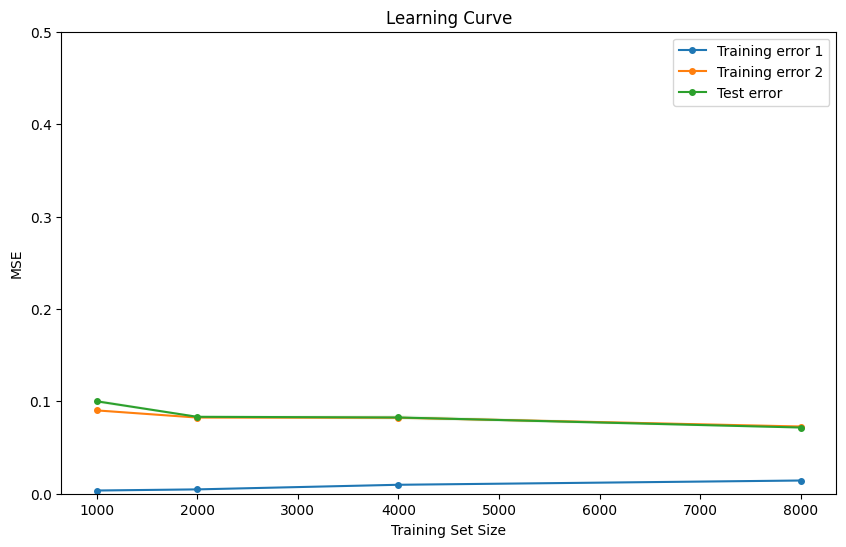

In [31]:
result_string = ""
for training_set_size in  train_sizes:
    train_scores1.append([])
    train_scores2.append([])
    test_scores.append([])
    
    for i in range(fold):
        #Creating Test Set
        
        test_set = dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        test_set_x = []
        test_set_y = []
        for j in range(len(test_set)):
            if one_hot:
                test_set_x.append([test_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(test_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                test_set_x.append([test_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(test_set.index[j][0]), padding)))
            test_set_y.append(test_set[j])

        #Creating Training Set
        training_set = dataset[~dataset['Map'].isin(test_maps)]
        training_set_sampled = training_set.sample(n=training_set_size, replace=True)
        if one_hot:
            training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['OneHotEncoded_Map'].apply(pd.Series).values, axis=1).astype('int64')
        else:
            training_set_x = np.append(training_set_sampled["Simulations"].values.reshape(-1, 1), training_set_sampled['Encoded_Map'].apply(pd.Series).values, axis=1)
        training_set_y = training_set_sampled["Discounted Return"].values
        
        #print("Maps seen in training: %d" % (len(training_set["Map"].unique())))
        #Creating Training Score 1 Set - Looking only sampled points
        training_score1_set = training_set_sampled.groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score1_set_x = []
        training_score1_set_y = []
        for j in range(len(training_score1_set)):
            if one_hot:
                training_score1_set_x.append([training_score1_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                training_score1_set_x.append([training_score1_set.index[j][1]] + encode_maze(add_padding(ast.literal_eval(training_score1_set.index[j][0]), padding)))
            training_score1_set_y.append(training_score1_set[j])
            
        #Creating Training Score 2 Set - Looking all datapoints in the training sample
        training_sampled_unique = training_set_sampled["Map"].unique()
        training_score2_set = training_set[training_set["Map"].isin(training_sampled_unique)].groupby(["Map", "Simulations"]).mean()["Discounted Return"]
        training_score2_set_x = []
        training_score2_set_y = []
        for i in range(len(training_score2_set)):
            if one_hot:
                training_score2_set_x.append([training_score2_set.index[j][1]] + list(np.reshape(encode_map(add_padding(ast.literal_eval(training_score2_set.index[j][0]), padding), categories=categories)[0], (-1))))
            else:
                training_score2_set_x.append([training_score2_set.index[i][1]] + encode_maze(training_score2_set.index[i][0]))
            training_score2_set_y.append(training_score2_set[i])


        # print("train score set info: ")
        # a = (training_set.groupby(["Map", "Simulations"]).std()["Discounted Return"] / (training_set.groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(a.mean())
        # print("test set info: ")
        # b = (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).std()["Discounted Return"] / (dataset[dataset['Map'].isin(test_maps)].groupby(["Map", "Simulations"]).count()["Discounted Return"] ** 0.5))
        # print(b.mean())
        #Training
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=200, activation='tanh', input_shape=(17,)),
            tf.keras.layers.Dense(units=200, activation='tanh'),
            tf.keras.layers.Dense(units=200, activation='tanh'),
            tf.keras.layers.Dense(units=200, activation='tanh'),
            tf.keras.layers.Dense(units=200, activation='tanh'),
            tf.keras.layers.Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(np.asarray(training_set_x).astype('float32'), training_set_y, epochs=1000, verbose = 1)
        #Predicting on test set
        y_pred = model.predict(np.asarray(test_set_x).astype('float32'))
        test_score = mean_squared_error(test_set_y, y_pred)
        test_scores[-1].append(test_score)
        
        #Predicting on training score 1 set
        y_pred = model.predict(np.asarray(training_score1_set_x).astype('float32'))
        train_score1 = mean_squared_error(training_score1_set_y, y_pred)
        train_scores1[-1].append(train_score1)
        
        #Predicting on training score 2 set
        y_pred = model.predict(np.asarray(training_score2_set_x).astype('float32'))
        train_score2 = mean_squared_error(training_score2_set_y, y_pred)
        train_scores2[-1].append(train_score2)
            
        # print("Fold: %d\nTraining set size: %d\nTraining error: %f\nTest error: %f\n" % (i, training_set_size, train_score, test_score))
    print("Training set size: %d\nTraining error 1: %f ± %f\nTraining error 2: %f ± %f\nTest error: %f ± %f\n" % (training_set_size, np.mean(train_scores1[-1]), np.std(train_scores1[-1]) / (fold ** 0.5), np.mean(train_scores2[-1]), np.std(train_scores2[-1]) / (fold ** 0.5), np.mean(test_scores[-1]), np.std(test_scores[-1]) / (fold ** 0.5)))

# Calculate the mean and standard deviation of the training and test scores
train1_mean = np.mean(train_scores1, axis=1)
train1_std = np.std(train_scores1, axis=1) / (fold ** 0.5)
train2_mean = np.mean(train_scores2, axis=1)
train2_std = np.std(train_scores2, axis=1) / (fold ** 0.5)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) / (fold ** 0.5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train1_mean, marker='o', markersize=4, label='Training error 1')
plt.plot(train_sizes, train2_mean, marker='o', markersize=4, label='Training error 2')
plt.plot(train_sizes, test_mean, marker='o', markersize=4, label='Test error')

# Add error bands showing the standard deviation
plt.fill_between(train_sizes, train1_mean - train1_std, train1_mean + train1_std, alpha=0.1)
plt.fill_between(train_sizes, train2_mean - train2_std, train2_mean + train2_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.ylim([0.0, 0.5])
plt.show()